# Multiple LSTMs

## Download and Prepare the Dataset

In [2]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU7TSA8/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU7TSA8/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU7TSA8/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

## Build and Compile the Model

In [4]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size, timesteps, features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


In [5]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635329 (2.42 MB)
Trainable params: 635329 

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the Model

In [9]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 73s 652ms/step - loss: 0.5678 - accuracy: 0.6860 - val_loss: 0.4497 - val_accuracy: 0.8093
Epoch 2/10
98/98 [==============================] - 48s 484ms/step - loss: 0.5747 - accuracy: 0.7123 - val_loss: 0.6793 - val_accuracy: 0.6171
Epoch 3/10
98/98 [==============================] - 56s 574ms/step - loss: 0.4544 - accuracy: 0.8080 - val_loss: 0.4783 - val_accuracy: 0.8135
Epoch 4/10
98/98 [==============================] - 44s 444ms/step - loss: 0.6094 - accuracy: 0.6509 - val_loss: 0.6514 - val_accuracy: 0.6052
Epoch 5/10
98/98 [==============================] - 42s 422ms/step - loss: 0.5566 - accuracy: 0.7176 - val_loss: 0.5429 - val_accuracy: 0.7439
Epoch 6/10
98/98 [==============================] - 41s 417ms/step - loss: 0.4050 - accuracy: 0.8404 - val_loss: 0.4775 - val_accuracy: 0.7854
Epoch 7/10
98/98 [==============================] - 40s 406ms/step - loss: 0.2996 - accuracy: 0.8872 - val_loss: 0.4132 - val_accuracy: 0.8239

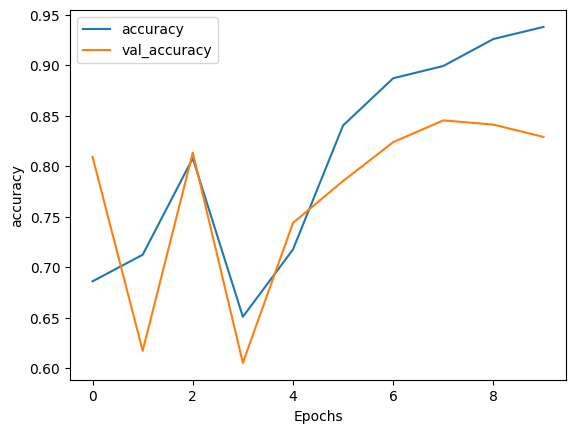

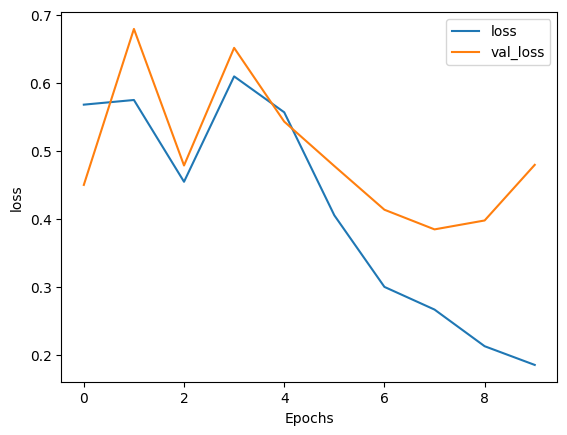

In [10]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")